# Predicting P0546 & P0544

## Import Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Load and review data

In [5]:
df = pd.read_csv("./data/P0546_P0544.csv")

In [6]:
df.shape

(1828, 5)

In [7]:
df.head(5)

,Odometer,speed,TripDuration,TotalEngineOnTime,DTC
0,257307.872,0,61,17692920,1
1,259413.943,0,2463,17852789,1
2,259413.943,0,2524,17852850,1
3,259413.943,0,3494,17853820,1
4,259413.943,0,3555,17853881,1


### Check for null values

In [5]:
df.isnull().values.any()

False

### Check for features coorelation

In [8]:
def plot_corr(df, size=8):
    """
    Blue-cyan-yellow-red-darkred ==> less to more correlated
    """
    corr = df.corr()
    fig, ax = plt.subplots(figsize = (size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)

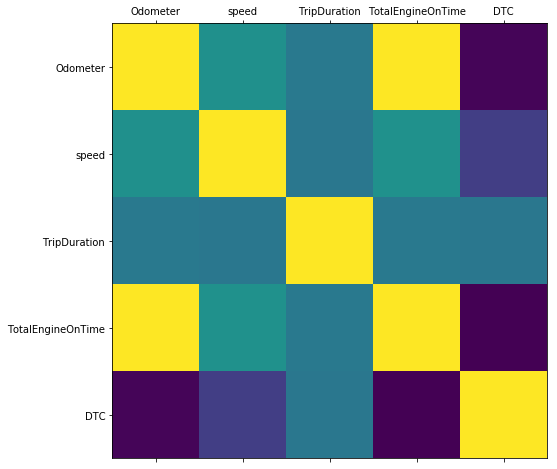

In [9]:
plot_corr(df)

In [10]:
df.corr()

,Odometer,speed,TripDuration,TotalEngineOnTime,DTC
Odometer,1.000000,0.196242,0.036920,0.997792,-0.594948
speed,0.196242,1.000000,0.027063,0.203577,-0.318174
TripDuration,0.036920,0.027063,1.000000,0.039328,0.022158
TotalEngineOnTime,0.997792,0.203577,0.039328,1.000000,-0.616257
DTC,-0.594948,-0.318174,0.022158,-0.616257,1.000000


In [12]:
del df['TotalEngineOnTime'] 

In [13]:
df.head(5)

,Odometer,speed,TripDuration,DTC
0,257307.872,0,61,1
1,259413.943,0,2463,1
2,259413.943,0,2524,1
3,259413.943,0,3494,1
4,259413.943,0,3555,1


In [14]:
df.corr()

,Odometer,speed,TripDuration,DTC
Odometer,1.000000,0.196242,0.036920,-0.594948
speed,0.196242,1.000000,0.027063,-0.318174
TripDuration,0.036920,0.027063,1.000000,0.022158
DTC,-0.594948,-0.318174,0.022158,1.000000


### Check true/false ratio

In [13]:
num_true = len(df.loc[df['DTC'] == 1])
num_false = len(df.loc[df['DTC'] == 0])
print("Number of True cases: {0} ({1:2.2f}%)".format(num_true, (num_true / (num_true + num_false)) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false / (num_true + num_false)) * 100))

Number of True cases: 210 (11.49%)
Number of False cases: 1618 (88.51%)


### Split the data

In [14]:
from sklearn.model_selection import train_test_split

feature_col_names = ['Odometer','speed','TripDuration']
predicted_class_names = ['DTC']

X = df[feature_col_names].values
y = df[predicted_class_names].values
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state = 42) 
# test_size = 0.3 is 30%, 42 is the answear to everything

we check to ensure we have the desired 70% train, 30% test split of the data

In [15]:
print("{0:0.2f}% in training set".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% in test set".format((len(X_test)/len(df.index)) * 100))

69.97% in training set
30.03% in test set


#### Verifying predicted value was splited correctly

In [159]:
print("Original True: {0} ({1:0.2f}%)".format(num_true, (num_true / (num_true + num_false)) * 100))
print("Original False: {0} ({1:0.2f}%)".format(num_false, (num_false / (num_true + num_false)) * 100))
print("")
print("Training True: {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1]) / len(y_train) * 100)))
print("Training False: {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0]) / len(y_train) * 100)))
print("")
print("Test True: {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1]) / len(y_test) * 100)))
print("Test False: {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0]) / len(y_test) * 100)))

Original True: 210 (11.49%)
Original False: 1618 (88.51%)

Training True: 154 (12.04%)
Training False: 1125 (87.96%)

Test True: 56 (10.20%)
Test False: 493 (89.80%)


### Post-split Data Preparation

#### Hidden missing values

In [16]:
print("# rows missing Odometer: {0}".format(len(df.loc[df['Odometer'] == 0])))
print("# rows missing speed: {0}".format(len(df.loc[df['speed'] == 0])))
print("# rows missing TripDuration: {0}".format(len(df.loc[df['TripDuration'] == 0])))

# rows missing Odometer: 0
# rows missing speed: 558
# rows missing TripDuration: 58


#### Impute with the mean

In [17]:
from sklearn.preprocessing import Imputer

fill_0 = Imputer(missing_values = 0, strategy = "mean", axis = 0)

X_train = fill_0.fit_transform(X_train)
X_test = fill_0.fit_transform(X_test)

## Training initial algorithm - Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

nb_model.fit(X_train, y_train.ravel())

GaussianNB(priors=None)

### Performance on Training Data

In [19]:
# Predict values using the training data
nb_predict_train = nb_model.predict(X_train)

from sklearn import metrics

# Accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, nb_predict_train)))

Accuracy: 0.9476


### Performance on Testing Data

In [20]:
# predict values using the testing data
nb_predict_test = nb_model.predict(X_test)

from sklearn import metrics

# Accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_test)))

Accuracy: 0.9435


#### Metrics

In [21]:
print("Confusion Metrics")
print("{0}".format(metrics.confusion_matrix(y_test, nb_predict_test)))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, nb_predict_test))

Confusion Metrics
[[493   0]
 [ 31  25]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      1.00      0.97       493
          1       1.00      0.45      0.62        56

avg / total       0.95      0.94      0.93       549



## Training algorithm - Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
rf_predict_train = rf_model.predict(X_train)
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, rf_predict_train)))

Accuracy: 0.9953


### Predict Test Data

In [24]:
rf_predict_test = rf_model.predict(X_test)
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, rf_predict_test)))

Accuracy: 0.9599


In [25]:
print(metrics.confusion_matrix(y_test, rf_predict_test))
print("")
print("Classifier Report")
print(metrics.classification_report(y_test, rf_predict_test))

[[489   4]
 [ 18  38]]

Classifier Report
             precision    recall  f1-score   support

          0       0.96      0.99      0.98       493
          1       0.90      0.68      0.78        56

avg / total       0.96      0.96      0.96       549



## Training algorithm - Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=1.4, class_weight="balanced", random_state=42)
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

In [27]:
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_test)))
print(metrics.confusion_matrix(y_test, lr_predict_test))
print("")
print("Classifier Report")
print(metrics.classification_report(y_test, lr_predict_test))

Accuracy: 0.7013
[[364 129]
 [ 35  21]]

Classifier Report
             precision    recall  f1-score   support

          0       0.91      0.74      0.82       493
          1       0.14      0.38      0.20        56

avg / total       0.83      0.70      0.75       549



### Logistic regression with class_weight='balanced'

In [28]:
C_start = 0.1
C_end = 5
C_inc = 0.1

C_values, recall_scores = [], []

C_val = C_start
best_recall_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    lr_model_loop = LogisticRegression(C=C_val, class_weight="balanced", random_state=42)
    lr_model_loop.fit(X_train, y_train.ravel())
    lr_predict_loop_test = lr_model_loop.predict(X_test)
    recall_score = metrics.recall_score(y_test, lr_predict_loop_test)
    recall_scores.append(recall_score)
    if (recall_score > best_recall_score):
        best_recall_score = recall_score
        best_lr_predict_test = lr_predict_loop_test
        
    C_val = C_val + C_inc
    
best_score_C_val = C_values[recall_scores.index(best_recall_score)]

Text(0,0.5,'recall score')

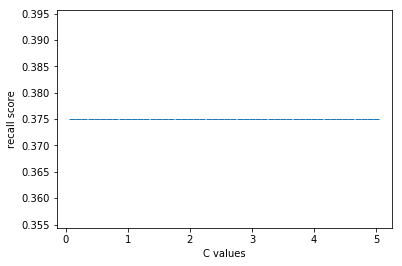

In [29]:
plt.plot(C_values, recall_scores, "_")
plt.xlabel("C values")
plt.ylabel("recall score")

In [30]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=best_score_C_val, class_weight="balanced", random_state=42)
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_test)))
print(metrics.confusion_matrix(y_test, lr_predict_test))
print("")
print("Classifier Report")
print(metrics.classification_report(y_test, lr_predict_test))
print(metrics.recall_score(y_test, lr_predict_loop_test))

Accuracy: 0.7013
[[364 129]
 [ 35  21]]

Classifier Report
             precision    recall  f1-score   support

          0       0.91      0.74      0.82       493
          1       0.14      0.38      0.20        56

avg / total       0.83      0.70      0.75       549

0.375


## Random Forest K-fold cross validation

In [173]:
# original accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, rf_predict_train)))
print("Accuracy: {0:.4f}".format(metrics.recall_score(y_train, rf_predict_train)))

Accuracy: 0.9961
Accuracy: 0.9675


### Grid Search with Cross Validation

In [174]:
# Look at parameters used by our current forest
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf_model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [95]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf_base = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_base, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [98]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train.ravel())
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.0min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 100}

In [101]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [117]:
best_grid = grid_search.best_estimator_
#grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test.ravel())

Model Performance
Average Error: 0.0346 degrees.
Accuracy = nan%.


C:\Users\fangyijie.wang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\fangyijie.wang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


## K-fold cross validation

### Logistic Regression

In [175]:
from sklearn.linear_model import LogisticRegressionCV
lr_cv_model = LogisticRegressionCV(n_jobs = -1, random_state = 42, Cs = 3, cv = 5, refit = False, class_weight = "balanced")
lr_cv_model.fit(X_train, y_train.ravel())

LogisticRegressionCV(Cs=3, class_weight='balanced', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
           refit=False, scoring=None, solver='lbfgs', tol=0.0001,
           verbose=0)

#### Predict on Test data

In [176]:
lr_cv_predict_test = lr_cv_model.predict(X_test)

print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_cv_predict_test)))
print(metrics.confusion_matrix(y_test, lr_cv_predict_test))
print("")
print("Classifier Report")
print(metrics.classification_report(y_test, lr_cv_predict_test))

Accuracy: 0.5774
[[261 232]
 [  0  56]]

Classifier Report
             precision    recall  f1-score   support

          0       1.00      0.53      0.69       493
          1       0.19      1.00      0.33        56

avg / total       0.92      0.58      0.65       549



In [177]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train.ravel())
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_pred)))

Accuracy of logistic regression classifier on test set: 1.00


In [178]:
# 10-fold cross validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

kfold = model_selection.KFold(n_splits=10, random_state=7)
#lr_cv_kfold = LogisticRegression()

scoring = 'accuracy'
lr_cv_kfold_score = model_selection.cross_val_score(lr_model, X_train, y_train.ravel(), cv = kfold, scoring = scoring)

print(lr_cv_kfold_score)
print("10-fold cross validation average accuracy Logistic: %.3f" % (lr_cv_kfold_score.mean()))

[0.6015625  0.6796875  0.671875   0.75       0.6875     0.6015625
 0.6171875  0.546875   0.5859375  0.61417323]
10-fold cross validation average accuracy Logistic: 0.636


### Random Forest

In [179]:
lr_rf_kfold_score = model_selection.cross_val_score(rf_model, X_train, y_train.ravel(), cv = kfold, scoring = scoring)

print(lr_rf_kfold_score)
print("10-fold cross validation average accuracy Random Forest: %.3f" % (lr_rf_kfold_score.mean()))

[0.984375   0.9609375  0.96875    0.953125   0.953125   0.9921875
 0.9765625  0.9921875  0.9765625  0.96062992]
10-fold cross validation average accuracy Random Forest: 0.972
